In [1]:
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% QUAD-ROTOR ATTITUDE CONTROL                                             %
% Author:  Soufiane El Omari (soufiane.elomari@polimi.it)                 %
% Date: 13/12/2021                                                        %
% Quadcopter Control System Design in MATLAB This project involves the    %
% design and analysis of a control system for the lateral dynamics of a   %
% quadcopter based on cascade architecture using MATLAB. The model used is%
% a linearized and decoupled at low speed, the derivation of which is not %
% covered in this work. Feel free to use any model and adjusting the      %
% requirements/inputs.                                                    %
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% Close all figures, clear workspace, and command window
close all
clear
clc

# Model
A state space representation of the lateral dynamics of a quadrotor is a decoupled model derived starting from the flight dynamics equations of the drone. This model is linearized using Poisson's formula and works only under the assumption of low speed to neglect couplings of dynamic modes. 

$\dot{x} = A x + B u \\
y = Cx + D u$

where 

$x = \left[\matrix{ v \cr p \cr \phi} \right] , \quad u = \delta_{lat},  \quad y = \left[\matrix{p \cr \phi} \right]$

$A = \left[\matrix{ Y_v & Y_p & g \cr L_v & L_p & 0 \cr 0 & 1 & 0} \right], \quad B = \left[\matrix{ Y_\delta \cr L_\delta \cr 0} \right], \quad C = \left[\matrix{ 0 & 1 & 0 \cr 0 & 0 & 1} \right], \quad D = \left[\matrix{0 \cr 0} \right].$




Assumptions

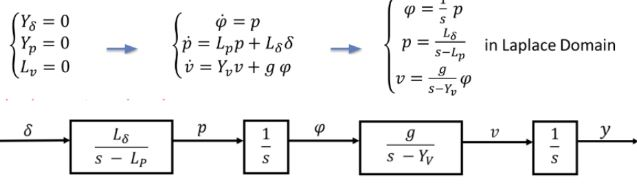


In [2]:
%% Model construction

% Defining nominal and uncertain parameters
s=tf('s');
Y_v = ureal('Y_v', -0.264,  'Percentage',[-3*4.837 3*4.837]); % [1/s]
Y_d = ureal('Y_d',  9.568,  'Percentage',[-3*4.647 3*4.647]); % [m/s^2]
L_v = ureal('L_v', -7.349,  'Percentage',[-3*4.927 3*4.927]); % [rad/(m s)]  
L_d = ureal('L_d', 1079.339,'Percentage',[-3*2.762 3*2.762]); % [rad/s^2]
Y_p=0;
L_p=0;

g = 9.81;                                                     % [m/s^2]
% State Space Model of the 
A = [Y_v Y_p g; L_v L_p 0; 0 1 0];
B = [Y_d L_d 0]';
C = [0 1 0; 0 0 1];
D = [0 0]';

% Defining The inputs and outputs of the system
% Uncertain Plant
sys_ld = ss(A,B,C,D);
sys_ld.u = '\delta_{lat}';
sys_ld.y = {'p','\phi'};
% Nominal Plant
sys_ld_nom = sys_ld.NominalValue;
sys_ld_nom.u = '\delta_{lat}';
sys_ld_nom.y = {'p','\phi'};
% Defining the dynamic blocks
G1=1/s;
G2=L_d.NominalValue/(s);
G3=g/(s-Y_v.NominalValue);
G4=1/s;
g2=L_d/(s-L_p); % Uncertain plant
g3=g/(s-Y_v);   % Uncertain plant
% Define internal inputs and outputs
G1.u = 'p'; G1.y='\phi';
G2.u = '\delta_{lat}'; G2.y='p';
G3.u = '\phi'; G3.y='v';
G4.u= 'v'; G4.y='y';
g2.u = '\delta_{lat}'; g2.y='p'; 
g3.u = '\phi'; g3.y='v';

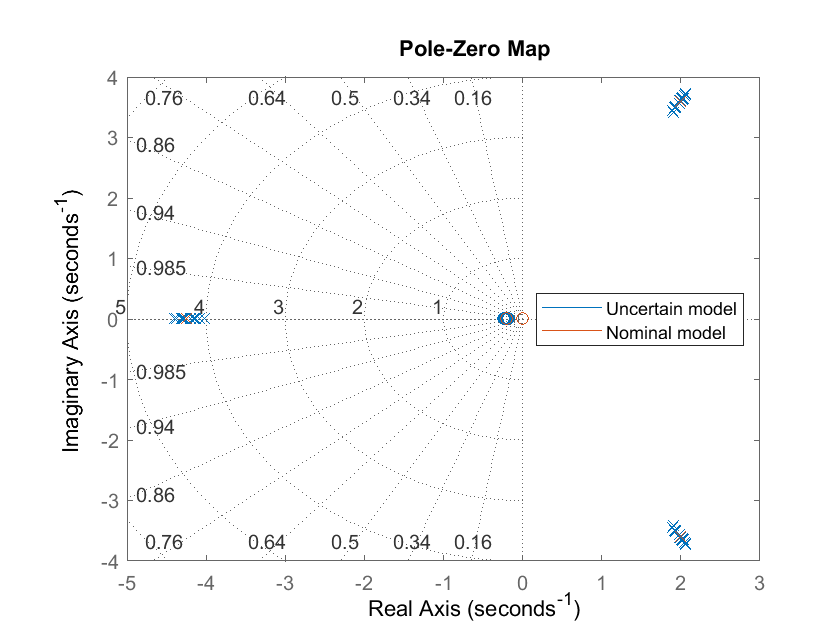

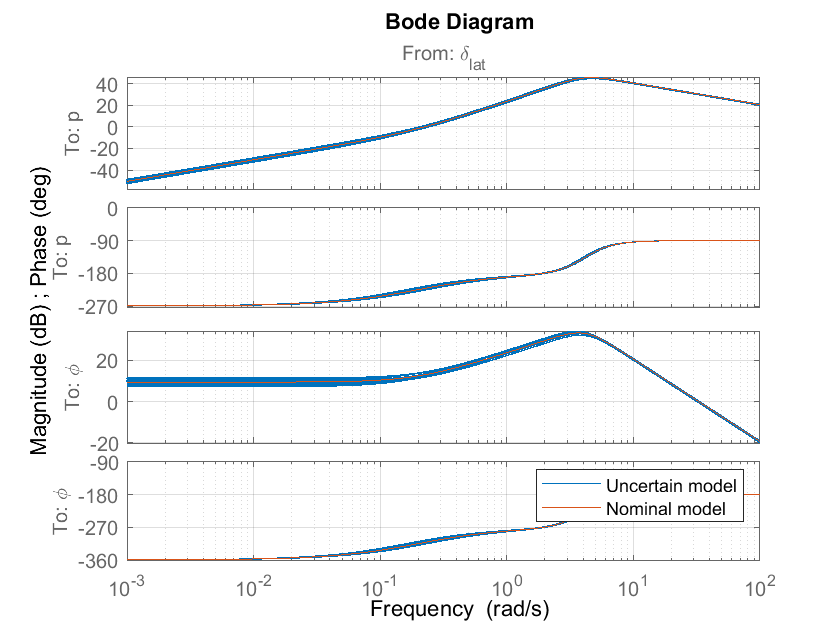

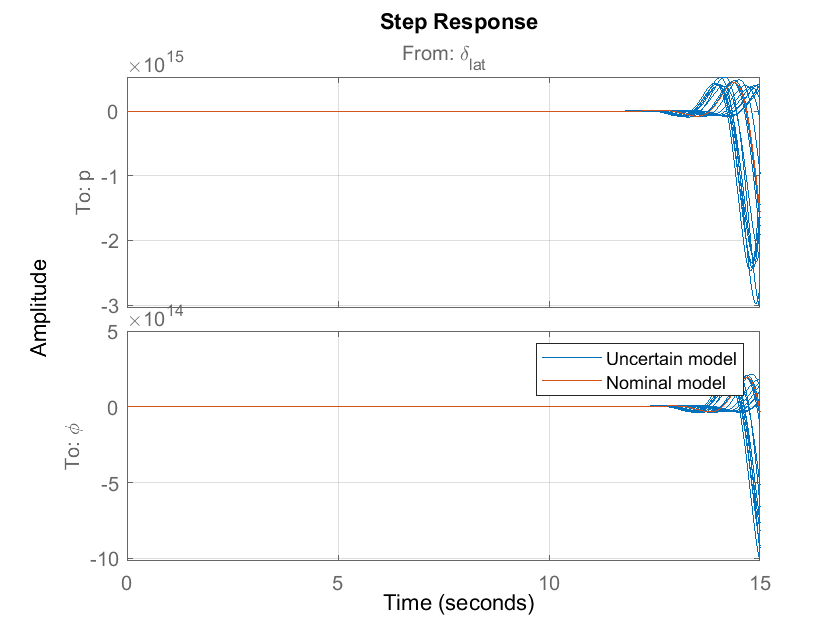

In [3]:
%% The model is unstable around the y axis due to the presenve of RHS poles
% Poles and zeros
figure; pzplot(sys_ld(1)); hold on; pzplot(sys_ld_nom(1)); grid on
legend('Uncertain model','Nominal model','location','east')

% Bode diagram
figure; bode(sys_ld); hold on; bode(sys_ld_nom); grid on
legend('Uncertain model','Nominal model','location','northeast')

% Step response
figure; step(sys_ld); hold on; step(sys_ld_nom); grid on
legend('Uncertain model','Nominal model','location','northeast')

# Controller - Attitude

The controller used for the lateral dynamics of the quadrotor is composed by a P - PID cascade.
Where the outer proportional controller for the roll angle is:

$p_0 = K_{P,\phi} e_\phi$

The proportional controller can be easily defined thorugh the function tunablePID, defining also its input and output.
The inner PID controller for the roll rate is:

$\delta_{lat} = K_{P,p} \left( p_0 - p\right) + \frac{K_{I,p}}{s} \left(p_0 -p\right) + \frac{sK_{D,p}}{1 + s T_f} \left(-p\right)$

To define the PID controller instead we have to use a PID with two degree of freedom since the inputs are  and . For this reason we use tunablePID2, expressed through the following formula

$\delta_{lat} = K_{P,p} \left( b p_0 - p\right) + \frac{K_{I,p}}{s} \left(p_0 -p\right) + \frac{sK_{D,p}}{1 + s T_f} \left(c p_0 - p\right)$

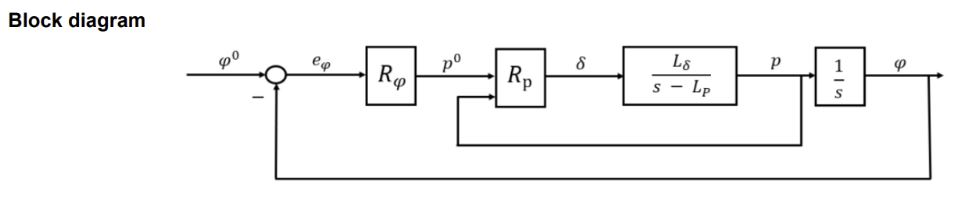


### Nominal design requirements
The design requirements are:
 - Nominal performance: response of $\phi$ to variations in $\phi_0$  equivalent to a second order response with $\omega_n \ge 10$ rad/s and $\xi \ge 0.9$.

 - Control effort limitation: $|\delta_{lat}| < 5$  for a given doublet change in $\phi_0$ of 10° amplitude.
 - Robust stability: ensure robustness of stability to model uncertainty.

a) Nominal performance
We can compute the settling time and the percentage overshoot of our desired approximated complementary sensitivity transfer function .

$F_2(s)  = \frac{\omega_n^2}{s^2 + 2\xi\omega_ns + \omega_n^2}$

Now we have to design our performance weight  that will be used in the $H_\infty$ synthesis. 

$W_p(s) = \frac{\frac{s}{M} + \omega_b}{s + A \omega_b}$

The objective is that $1/W_p(s)$ is used to shape our sensitivity function in order to have .
Where M is related to the peak, A is related to the value at steady state and  is related to the cross-over frequency and so to the settling time of our response.

### Control effort limitation
For the doublet change in $\phi_0$ of 10° amplitude shown in the figure, we want $|\delta_{lat}| < 5 $. 
The weight on control sensitivity has the important function to keep the control action moderated; indeed, in practice control action is provided by actuators, which have limited control authority both in range and rate; also, the actuator bandwidth is limited, i.e., one should not demand the actuator a control action which is beyond its capabilities.

We have to design our performance weight  that will be used in the $H_\infty$ synthesis.

$W_q(s) = \alpha \frac{s + \omega_{act} 10^{-3}}{s +  \omega_{act}}$

where  is related to the frequency of the actuators, while  represent the high frequency gain of the weight  and shall be large enough so as to limit the magnitude of  beyond the bandwidth. For a doublet input in , we can  compute the peak of the response using the initial value theorem for a step input of two times the doublet amplitude:

$\lim_{t\rightarrow0} \delta_{lat} = \lim_{s\rightarrow \infty} s Q(s) \frac{A}{s} = \lim_{s\rightarrow \infty} Q(s) A = \frac{A}{\alpha}$

since we want to have $|\delta_{lat}| < 5 $ for A=deg2rad(20). 

In [4]:
%Attitude control
% 1-dof controller for the roll angle
R_phi = tunablePID('R_phi','P');
R_phi.u = 'e_\phi';
R_phi.y = 'p_\0';

% 2-dof controller for the roll rate
R_p = tunablePID2('R_p','PID');
R_p.c.Value = 0;
R_p.c.Free = false;
R_p.b.Value = 1;
R_p.b.Free = false;
R_p.Tf.Value = 0.01;
R_p.Tf.Free = false;
R_p.u = {'p_\0','p'};
R_p.y = {'\delta_{lat}'};

% Loop connection
SumOuter1 = sumblk('e_\phi = \phi_0 - \phi');

% Defining the requirements
omega_n_1 = 10;
xi_1 = 0.9;
F_req_1 = omega_n_1^2/(s^2 + 2*s*xi_1*omega_n_1 + omega_n_1^2);
S_req_1 = 1-F_req_1;
t1 = linspace(0,6,10^4);
u1 = 0*(t1<=1) + 10*(t1>1 & t1<= 3) - 10*(t1>3 & t1<= 5) + 0*(t1>5);
u1_rad = deg2rad(u1);

% Defining the weight parameters
M_1 = 1.3;
A_1 = 1e-3;
omega_b_1 = 0.9*omega_n_1;
alpha_1 = deg2rad(20)/5;
w_tau_1 = 10;

% Degining the weights
W_p_1 = (s/M_1 + omega_b_1)/(s + A_1*omega_b_1);
W_p2inv_1 = makeweight(1e-3,8,1.3,0,1);
W_p2_1 = 1/W_p2inv_1;
W_q_1 = alpha_1*(s+w_tau_1*1e-3)/(s+w_tau_1);

W_p_1.u = 'e_\phi';
W_p_1.y = 'z_1';
W_q_1.u = '\delta_{lat}';
W_q_1.y = 'z_2';

% Weighted system
CL0_att = connect(R_p, R_phi,G2, G1, SumOuter1, W_p_1, W_q_1,...
    '\phi_0',{'z_1','z_2'},{'\delta_{lat}','e_\phi','\phi'});

% Optimization using Hinfstruct
opt_att = hinfstructOptions('Display','final','RandomStart',10);
[CL_att,gamma,info] = hinfstruct(CL0_att,opt_att);

% Optimized functions
showTunable(CL_att);
F1 = getIOTransfer(CL_att,'\phi_0','\phi');
S1 = getIOTransfer(CL_att,'\phi_0','e_\phi');
Q1 = getIOTransfer(CL_att,'\phi_0','\delta_{lat}');
L1 = (1-S1)/S1;
stepinfo(F1)

Final: Peak gain = 0.8, Iterations = 49
       Some closed-loop poles are marginally stable (decay rate near 1e-07)
Final: Peak gain = 0.8, Iterations = 52
       Some closed-loop poles are marginally stable (decay rate near 1e-07)
Final: Peak gain = 0.8, Iterations = 50
       Some closed-loop poles are marginally stable (decay rate near 1e-07)
Final: Peak gain = 0.8, Iterations = 50
Final: Peak gain = 0.8, Iterations = 46
Final: Peak gain = 0.8, Iterations = 58
Final: Peak gain = 0.8, Iterations = 42
       Some closed-loop poles are marginally stable (decay rate near 1e-07)
Final: Peak gain = 0.8, Iterations = 57
       Some closed-loop poles are marginally stable (decay rate near 1e-07)
Final: Peak gain = 0.8, Iterations = 61
Final: Peak gain = 0.8, Iterations = 42
Final: Peak gain = 0.8, Iterations = 42
       Some closed-loop poles are marginally stable (decay rate near 1e-07)
R_p =
 
                       1                s    
  u = Kp (b*r-y) + Ki --- (r-y) + Kd -------- (c*r

ans = struct with fields:
         RiseTime: 0.1879
    TransientTime: 0.3379
     SettlingTime: 0.3379
      SettlingMin: 0.9005
      SettlingMax: 0.9993
        Overshoot: 0
       Undershoot: 0
             Peak: 0.9993
         PeakTime: 0.6257

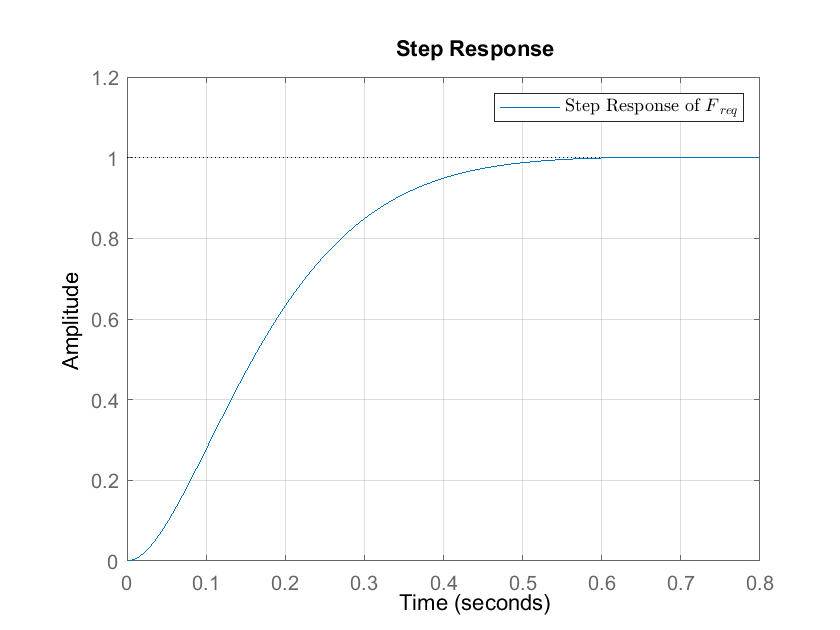

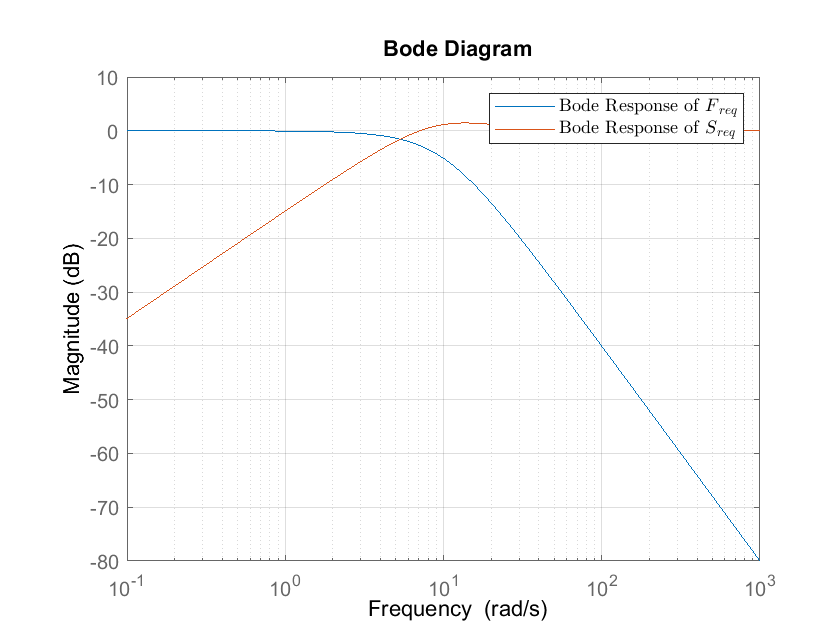

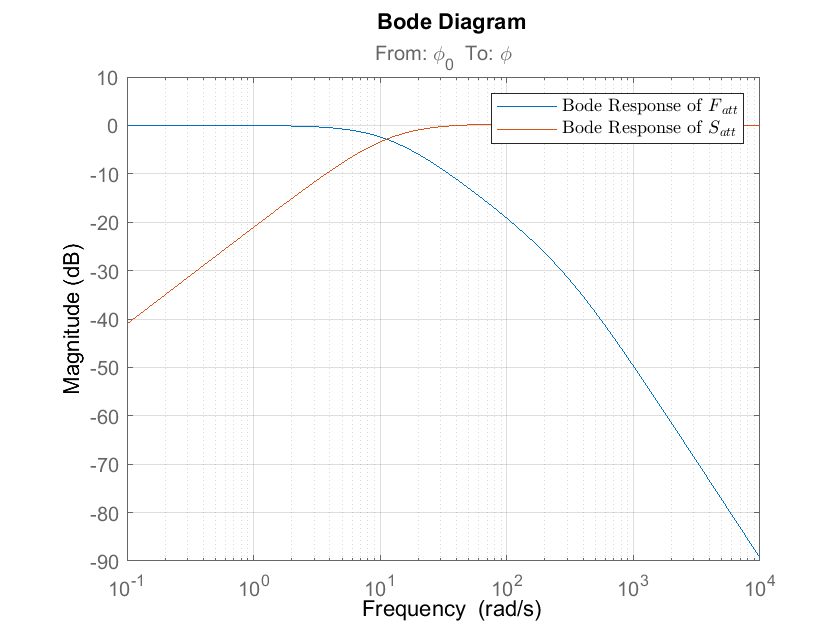

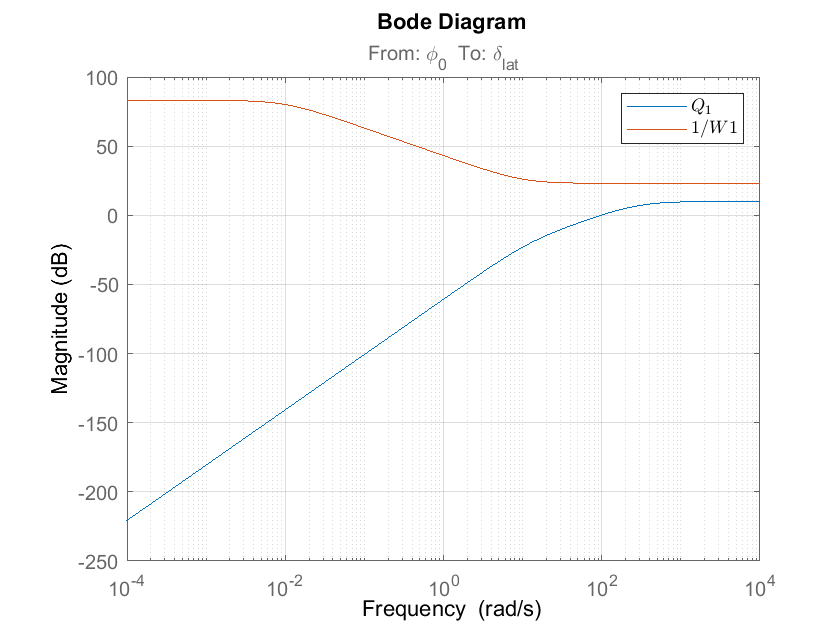

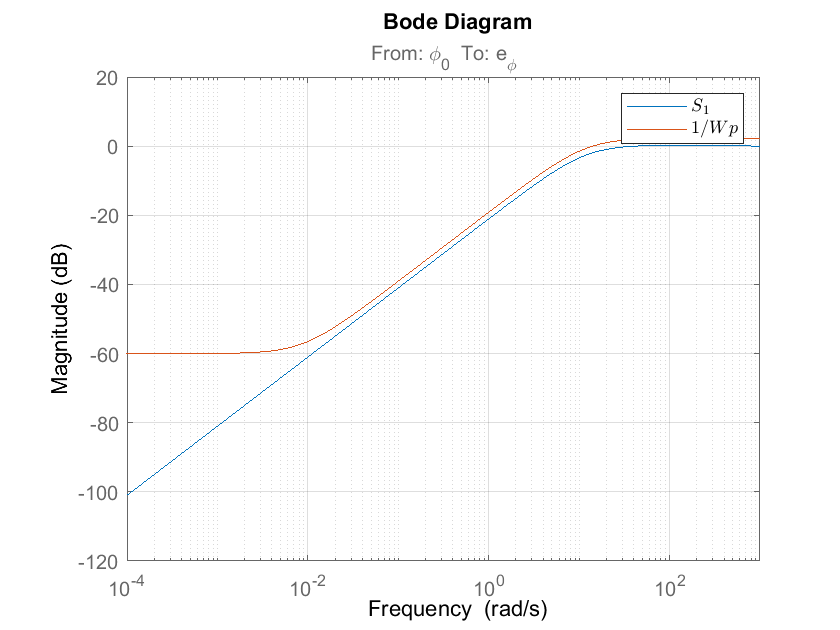

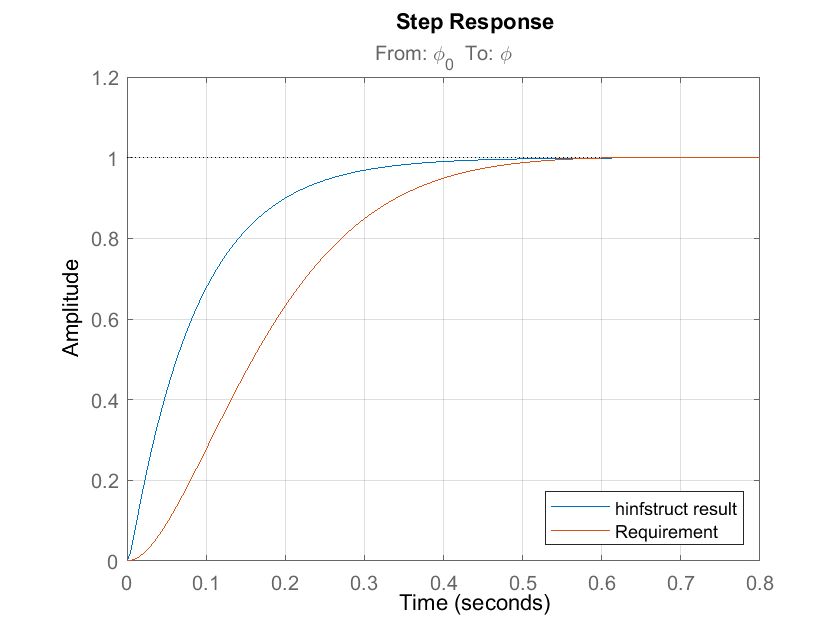

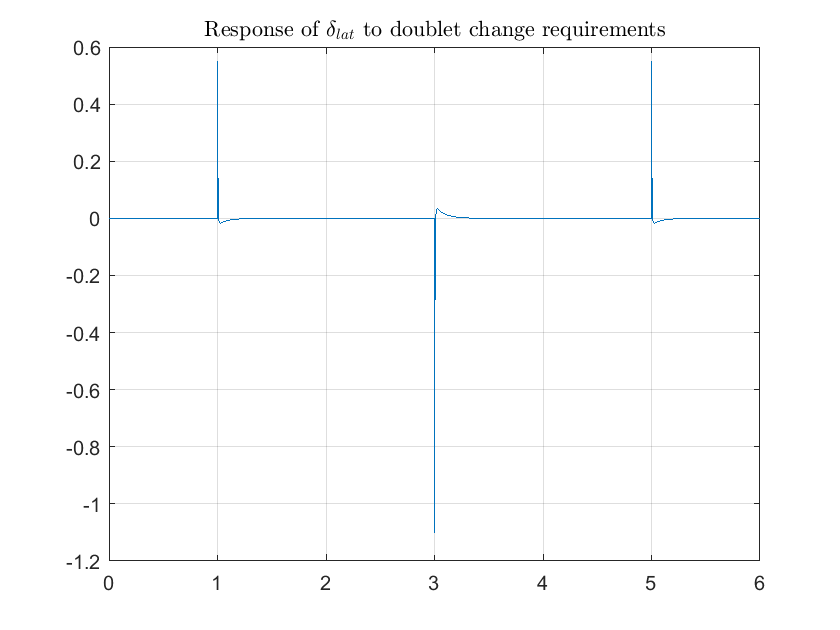

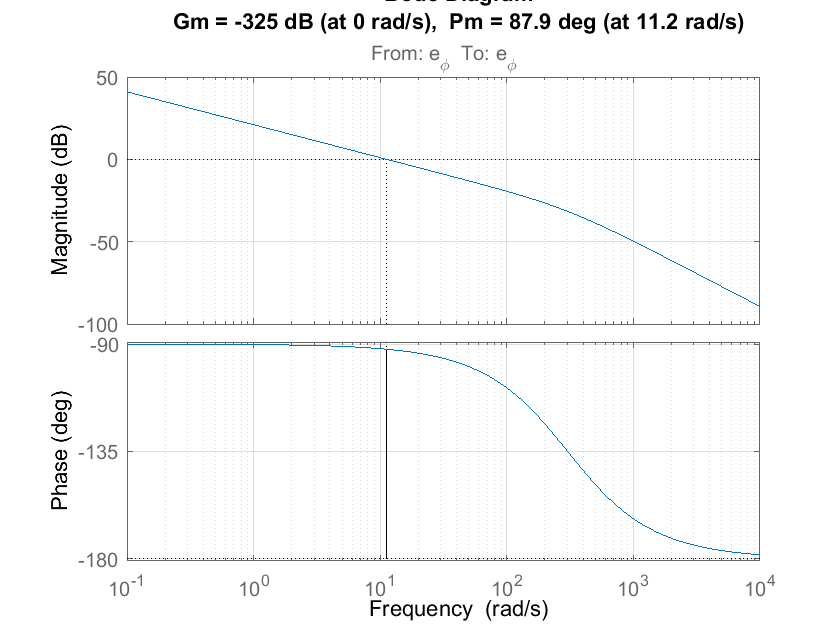

In [5]:
%% Plotting 

figure; step(F_req_1); grid on
legend('Step Response of $F\_{req}$','interpreter','latex')

figure; bodemag(F_req_1); hold on; bodemag(S_req_1);grid on
legend('Bode Response of $F\_{req}$', 'Bode Response of $S\_{req}$','interpreter','latex')

figure; bodemag(F1); hold on; bodemag(S1);grid on
legend('Bode Response of $F\_{att}$', 'Bode Response of $S\_{att}$','interpreter','latex')

figure; bodemag(Q1); hold on; bodemag(1/W_q_1);grid on
legend('$Q\_{1}$', '$1/W1$','interpreter','latex')

figure; bodemag(S1); hold on; bodemag(1/W_p_1);grid on
legend('$S\_{1}$', '$1/Wp$','interpreter','latex')

figure; step(F1); hold on; step(F_req_1); grid on
legend('hinfstruct result','Requirement', 'location','southeast')

[y1,~,~]=lsim(Q1,u1_rad,t1); figure; plot(t1,y1); grid on
title('Response of $\delta_{lat}$ to doublet change requirements','Interpreter','latex')

figure; margin(L1); grid on

# Controller - Position
The controller used  is composed by a P - PID cascade.
Where the outer proportional controller is:

$v_0 = K_{P,y} e_y$

The proportional controller can be easy defined thorugh the function tunablePID, defining also its input and output.
The inner PID controller is:

$\phi_0 = K_{P,p} \left( v_0 - v\right) + \frac{K_{I,p}}{s} \left(v_0 -v\right) + \frac{sK_{D,p}}{1 + s T_f} \left(-v\right)$

To define the PID controller instead we have to use a PID with two degree of freedom since the inputs are  and . For this reason we use tunablePID2, expressed through the following formula

$\phi_0 = K_{P,p} \left( b v_0 - v\right) + \frac{K_{I,p}}{s} \left(v_0 -v\right) + \frac{sK_{D,p}}{1 + s T_f} \left(c v_0 - v\right)$

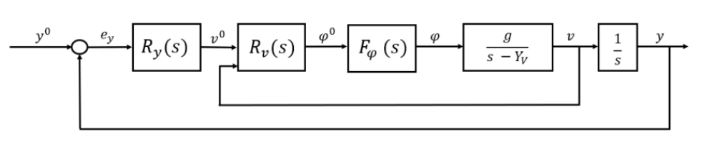

### Nominal design requirements

The design requirements are:

 - Nominal performance: response of  to variations in  equivalent to a second order response with  rad/s and .
 - Control effort limitation:  for a given doublet change in  of 1 m amplitude.
 - Robust stability: ensure robustness of stability to model uncertainty.
 
a) Nominal performance
We can compute the settling time and the percentage overshoot of our desired approximated complementary sensitivity transfer function .

$F_2(s)  = \frac{\omega_n^2}{s^2 + 2\xi\omega_ns + \omega_n^2}$

Now we have to design our performance weight $W_p(s)$ that will be used in the $H_\infty$ synthesis. 

$W_p(s) = \frac{\frac{s}{M} + \omega_b}{s + A \omega_b}$

The objective is that $1/W_p(s)$ is used to shape our sensitivity function in order to have $S(s) \simeq S_2(s)$.
Where M is related to the peak, A is related to the value at steady state and $\omega_b$ is related to the cross-over frequency and so to the settling time of our response.

b) Control effort limitation
For the doublet change in  of 1 m amplitude shown in the figure, we want $|\phi| < 25^{\circ} $. 
The weight on control sensitivity has the important function to keep the control action moderated; indeed, in practice control action is provided by actuators, which have limited control authority both in range and rate; also, the actuator bandwidth is limited, i.e., one should not demand the actuator a control action which is beyond its capabilities.
We have to design our performance weight that will be used in the $H_\infty$ synthesis.

$W_q(s) = \alpha \frac{s + \omega_{act} 10^{-3}}{s +  \omega_{act}}$

where $\omega_{act}$ is related to the frequency of the actuators, while $\alpha$ represent the high frequency gain of the weight Wq and shall be large enough so as to limit the magnitude of Q(s) beyond the bandwidth. For a doublet input in y0, we can  compute the peak of the response using the initial value theorem for a step input of two times the doublet amplitude:

$\lim_{t\rightarrow0} \phi = \lim_{s\rightarrow \infty} s Q(s) \frac{A}{s} = \lim_{s\rightarrow \infty} Q(s) A = \frac{A}{\alpha}$

since we want $|\phi| < 25^{\circ} $ to have for A=2m. 

Final: Peak gain = 0.898, Iterations = 59
       Some closed-loop poles are marginally stable (decay rate near 1e-07)
Final: Peak gain = 0.897, Iterations = 51
Final: Peak gain = 0.898, Iterations = 49
       Some closed-loop poles are marginally stable (decay rate near 1e-07)
Final: Peak gain = 0.897, Iterations = 73
Final: Peak gain = 0.897, Iterations = 55
Final: Peak gain = 0.898, Iterations = 44
       Some closed-loop poles are marginally stable (decay rate near 1e-07)
Final: Peak gain = 0.898, Iterations = 52
       Some closed-loop poles are marginally stable (decay rate near 1e-07)
Final: Peak gain = 0.898, Iterations = 50
       Some closed-loop poles are marginally stable (decay rate near 1e-07)
Final: Peak gain = 0.898, Iterations = 37
       Some closed-loop poles are marginally stable (decay rate near 1e-07)
Final: Peak gain = 0.898, Iterations = 42
Final: Peak gain = 0.897, Iterations = 61
R_v =
 
                       1                s    
  u = Kp (b*r-y) + Ki --- (r

ans = struct with fields:
         RiseTime: 1.6102
    TransientTime: 3.1719
     SettlingTime: 3.1719
      SettlingMin: 0.9042
      SettlingMax: 0.9989
        Overshoot: 0
       Undershoot: 0
             Peak: 0.9989
         PeakTime: 6.7227

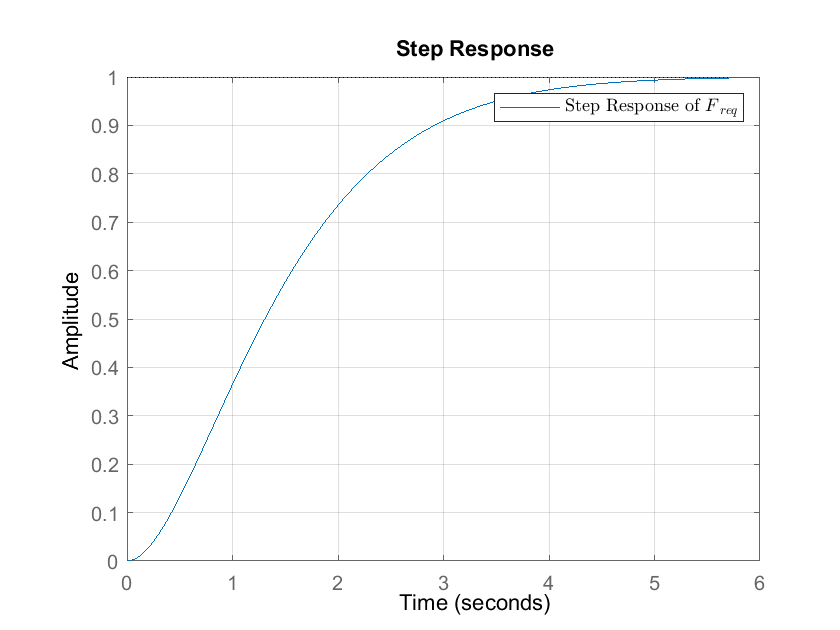

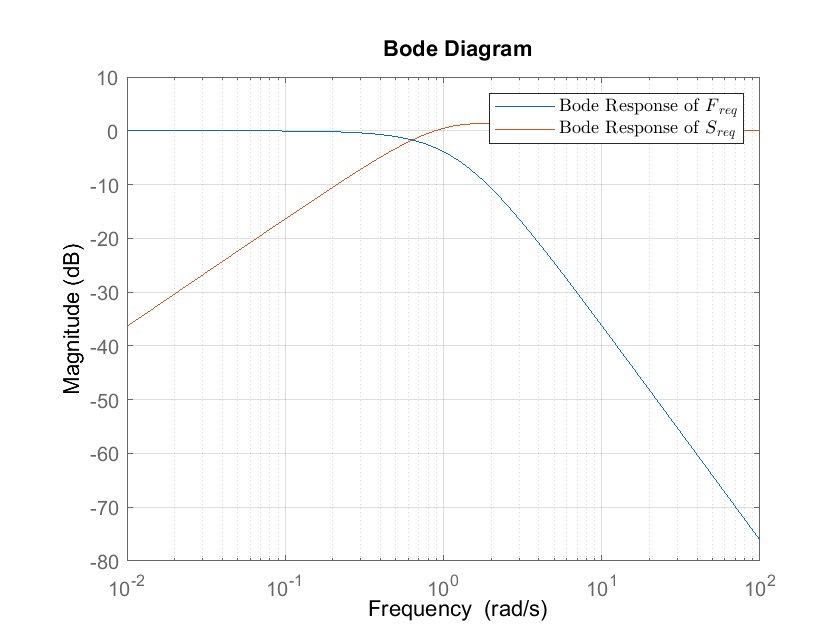

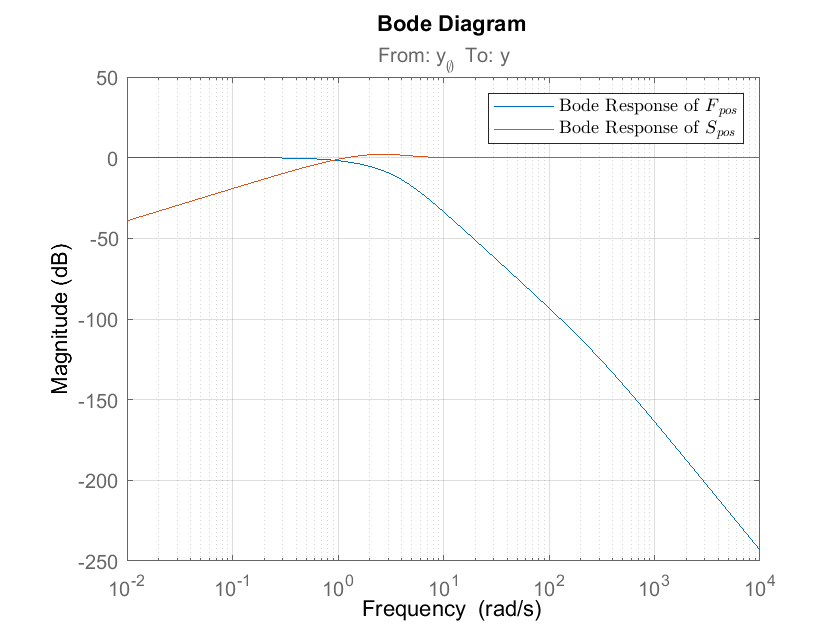

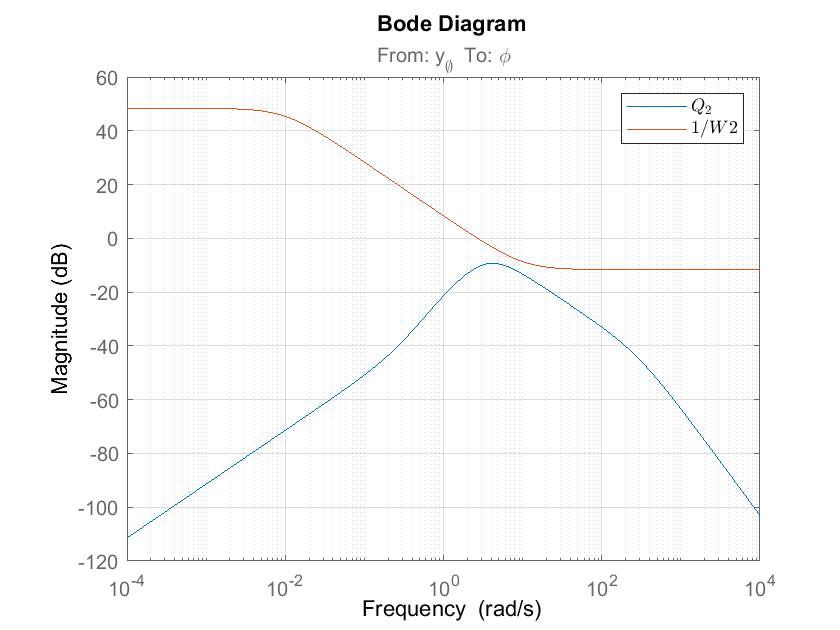

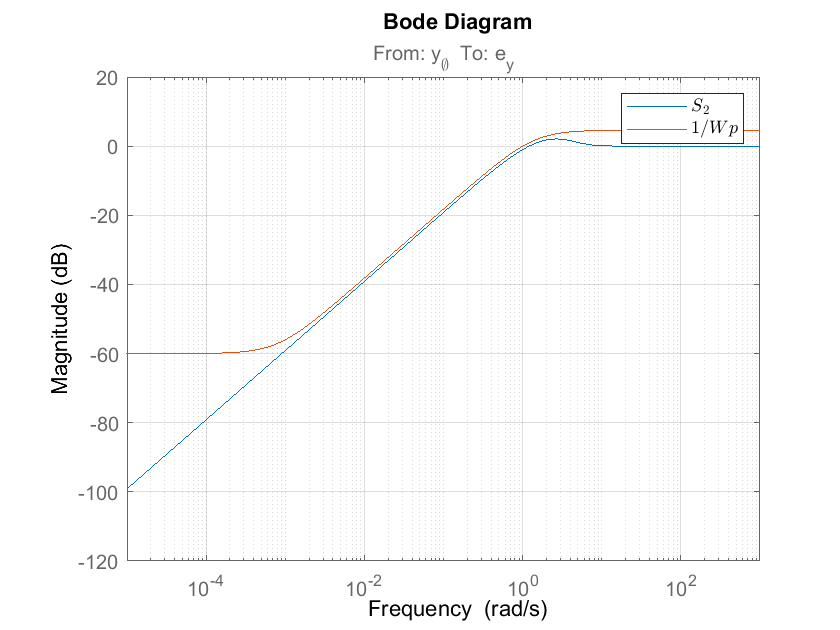

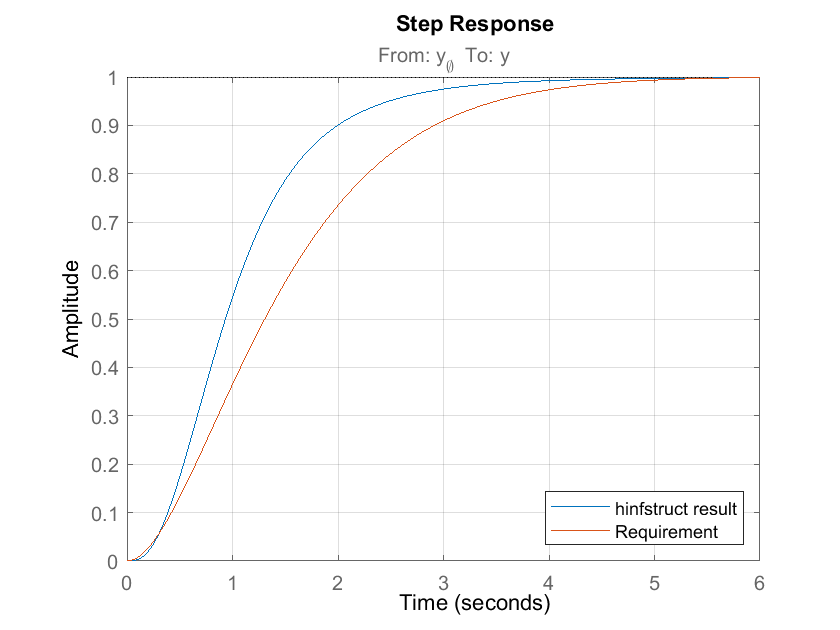

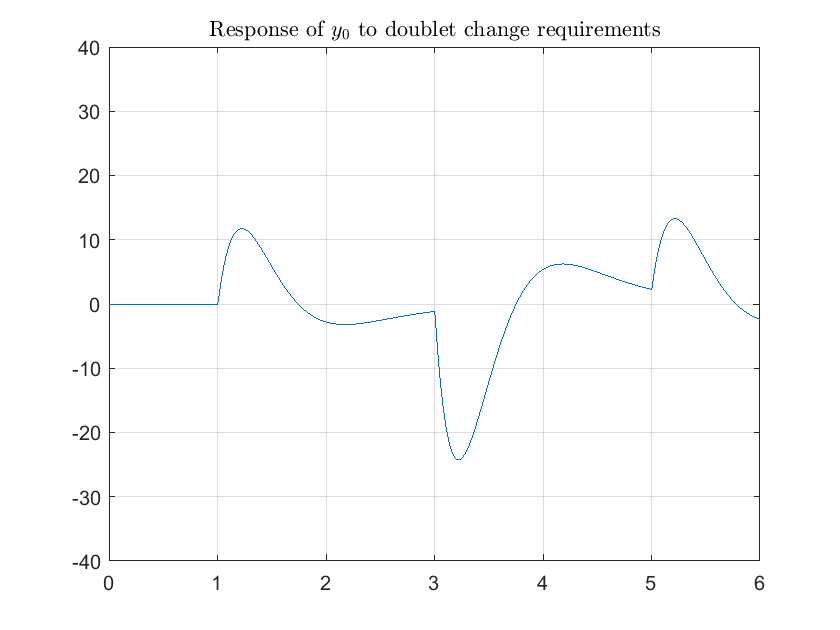

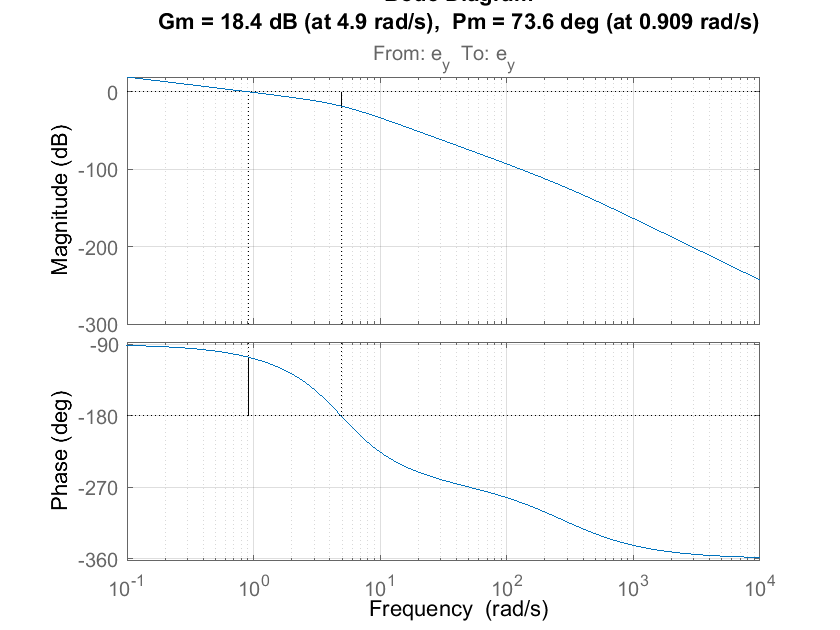

In [6]:
%Position control
% 1-dof controller for lateral position
R_y = tunablePID('R_y','P');
R_y.u = 'e_y';
R_y.y = 'v_\0';

% 2-dof controller for lateral velocity
R_v = tunablePID2('R_v','PID');
R_v.c.Value = 0;
R_v.c.Free = false;
R_v.b.Value = 1;
R_v.b.Free = false;
R_v.Tf.Value = 0.01;
R_v.Tf.Free = false;
R_v.u = {'v_\0','v'};
R_v.y = {'\phi_0'};

% Loop connection
SumOuter2 = sumblk('e_y = y_\0 - y');

% Defining requirements
omega_n_2 = 1.25;
xi_2 = 0.95;
F_req_2 = omega_n_2^2/(s^2 + 2*s*xi_2*omega_n_2 + omega_n_2^2);
S_req_2 = 1-F_req_2;
t2 = linspace(0,6,10^4);
u2 = 0*(t2<=1) + 1*(t2>1 & t2<= 3) - 1*(t2>3 & t2<= 5) + 0*(t2>5);

% Defining the weight parameters
M_2 = 1.7;
A_2 = 1e-3;
omega_b_2 = 0.65*omega_n_2;
alpha_2 = 2/deg2rad(30);
w_tau_2 = 10;

% Defining the weights
W_p_2 = (s/M_2 + omega_b_2)/(s + A_2*omega_b_2);
W_q_2 = alpha_2*(s+w_tau_2*1e-3)/(s+w_tau_2);
W_p_2.u = 'e_y';
W_p_2.y = 'z_1_pos';
W_q_2.u = '\phi';
W_q_2.y = 'z_2_pos';

% Weighted system
CL0_pos = connect(SumOuter2,R_y,R_v,tf(F1),G3,G4,W_p_2,W_q_2, ...
   'y_\0',{'z_1_pos','z_2_pos'},{'y','e_y','\phi'});  

% Optimization using Hinfstruct
opt_pos = hinfstructOptions('Display','final','RandomStart',10);
[CL_pos,gamma_pos,info_pos] = hinfstruct(CL0_pos,opt_pos);

% Optimized functions
showTunable(CL_pos)
F2 = getIOTransfer(CL_pos,'y_\0','y');
S2 = getIOTransfer(CL_pos,'y_\0','e_y');
Q2 = getIOTransfer(CL_pos,'y_\0','\phi');
L2 = (1-S2)/S2;
stepinfo(F2)
%% Plotting

figure; step(F_req_2); grid on
legend('Step Response of $F\_{req}$','interpreter','latex')

figure; bodemag(F_req_2); hold on; bodemag(S_req_2);grid on
legend('Bode Response of $F\_{req}$', 'Bode Response of $S\_{req}$','interpreter','latex')

figure; bodemag(F2); hold on; bodemag(S2);grid on
legend('Bode Response of $F\_{pos}$', 'Bode Response of $S\_{pos}$','interpreter','latex')

figure; bodemag(Q2); hold on; bodemag(1/W_q_2);grid on
legend('$Q\_{2}$', '$1/W2$','interpreter','latex')

figure; bodemag(S2); hold on; bodemag(1/W_p_2);grid on
legend('$S\_{2}$', '$1/Wp$','interpreter','latex')

figure; step(F2); hold on; step(F_req_2); grid on
legend('hinfstruct result','Requirement', 'location','southeast')

[y2,~,x2]=lsim(Q2,u2,t2); figure; plot(t2,y2*180/pi); axis([0 6 -40 40]); grid on
title('Response of $y_0$ to doublet change requirements','Interpreter','latex')

figure; margin(L2); grid on

# Robust stability analysis
For RS we have to verify that:

$ \left|W(j\omega) \bar{F}(j\omega)\right| < 1 \quad \quad \forall \omega$

where  is the closed-loop nominal complementary sensitivity, while  is a weight related to the uncertainty that represents an upperbound for the relative error between the nominal and the uncertaint plants.
We consider our model uncertainty associated with  ranges on all parameters.
First we create an array sampling our uncertain model, then we can construct our  bounding the relative error using ucover.

# Robust performance verification

Robust performance are obtained if and only if 

$\left|W_p(j\omega) \bar{S}(j\omega \right| + \left|W(j\omega) \bar{F}(j\omega \right| \le 1 \quad \quad \forall \omega$

This condition can be checked graphically.

In [7]:
% Robust stability and performance

% Attitude
w = logspace(-5,5,500);
G_att_array = usample(sys_ld(2),60); % we sample our the TF from phi_0 to phi in 60 samples
[~,Info] = ucover(G_att_array,sys_ld_nom(2),3);
W_att = Info.W1; % our W covers all the relative errors
FW_att = bode(F1*W_att,w); % Robust stability
SW_att = bode(S1*W_p_1,w); % Nominal performance


% Position
F_unc = connect(SumOuter1,tf(setBlockValue(R_phi,CL_att)), ...
tf(setBlockValue(R_p,CL_att)),G1,g2,'\phi_0','\phi');
G_pos_unc = connect(F_unc,g3,G4,'\phi_0','y');
G_pos_nom = connect(tf(F1),G3,G4,'\phi_0','y');
G_pos_array = usample(G_pos_unc,60);
[~,Info_pos] = ucover(G_pos_array,G_pos_nom,3);
W_pos = Info_pos.W1;
FW_pos = bode(F2*W_pos,w); % Robust stability
SW_pos = bode(S2*W_p_2,w); % Nominal performance

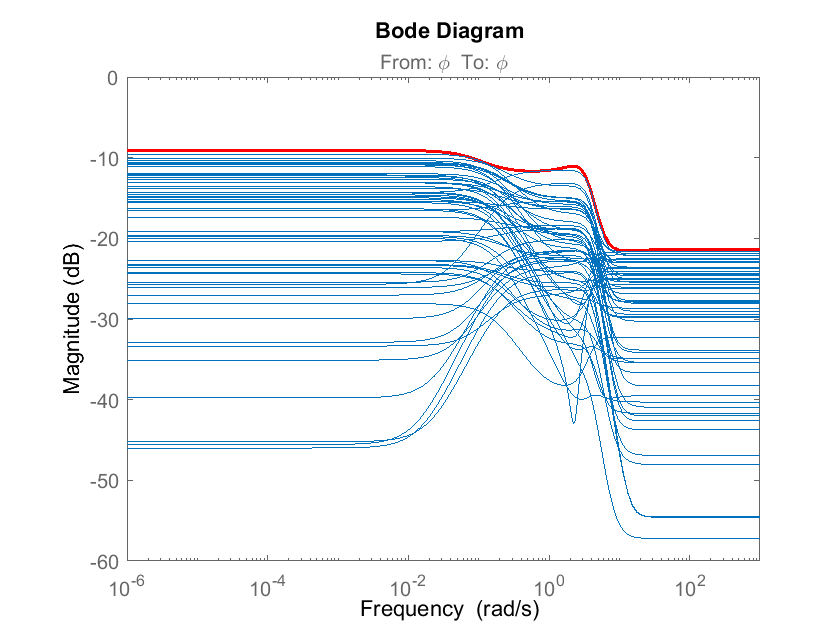

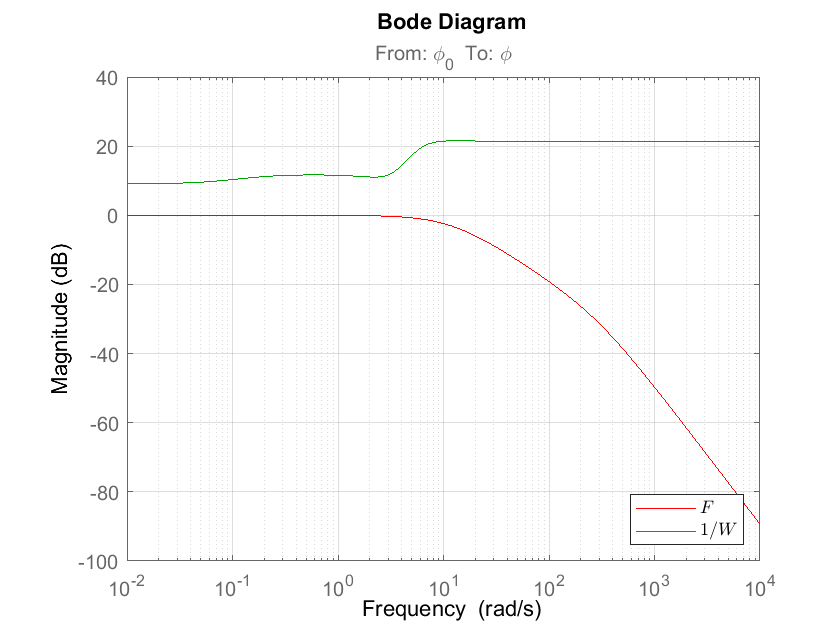

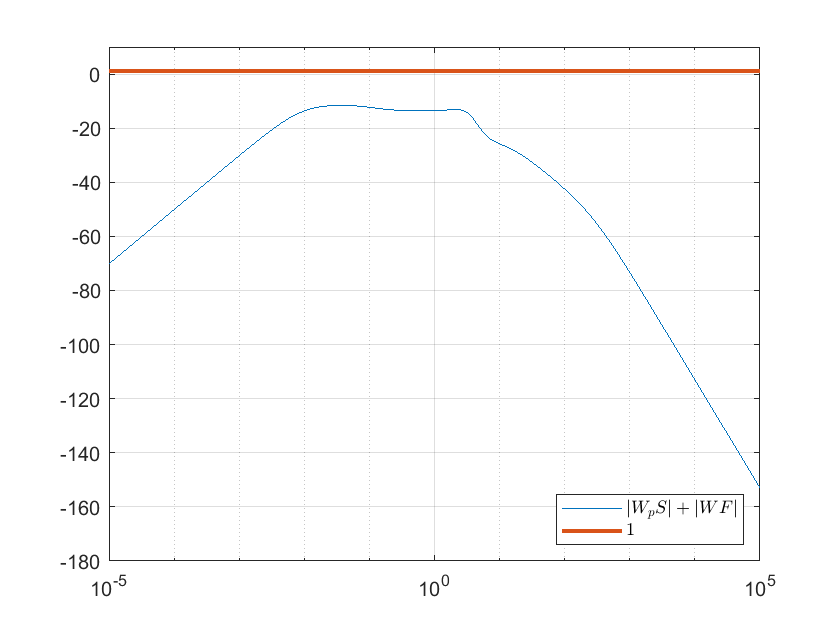

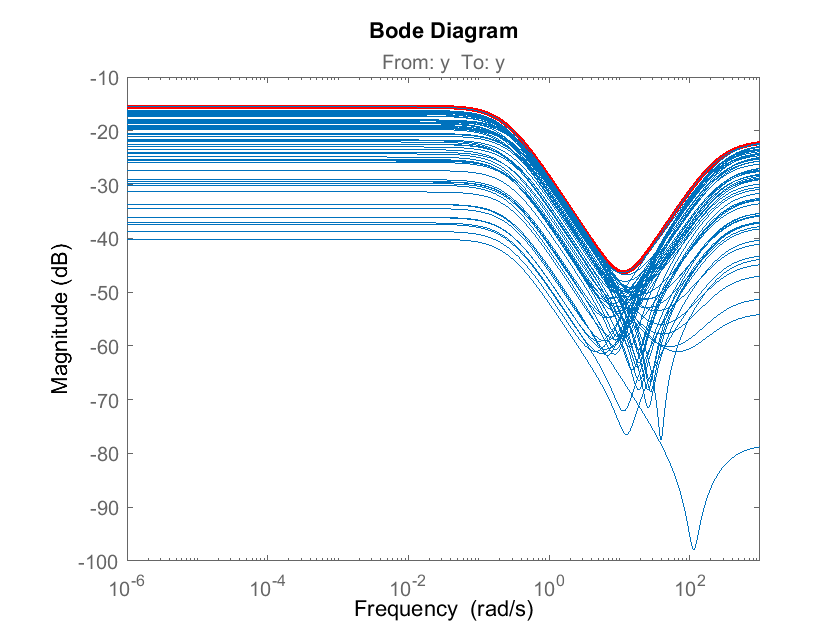

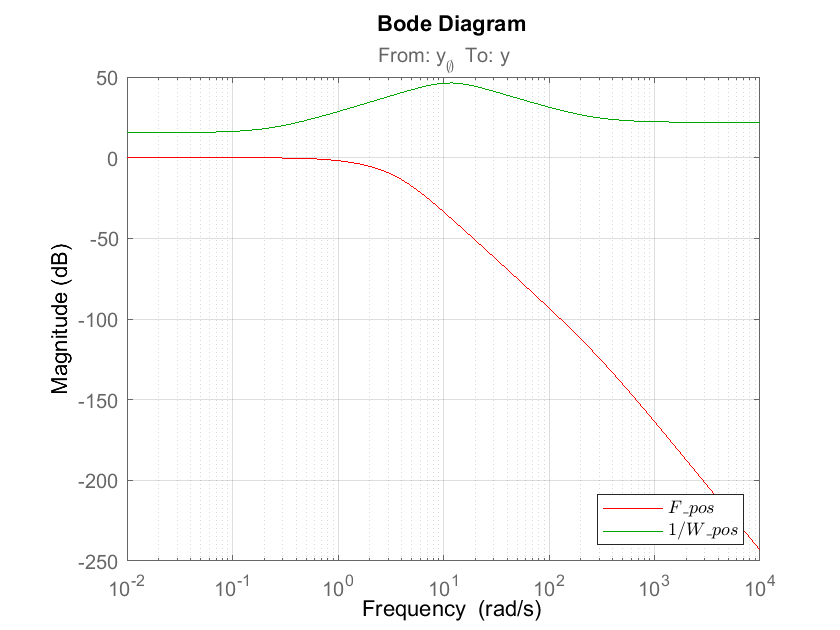

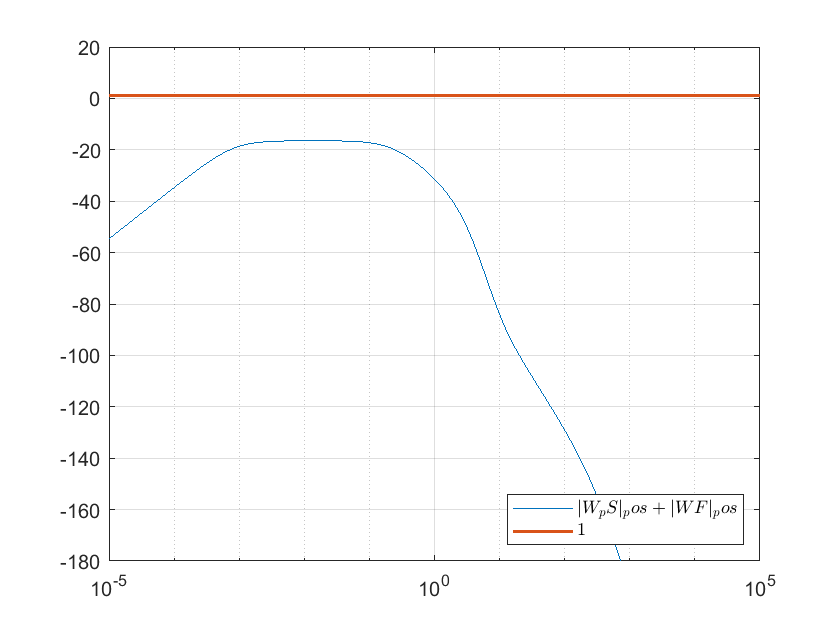

In [8]:
%% Plotting

[mag1,~,wout1] = bode(W_att,{10^-6,10^3});Mag1=20*log10(mag1(:));
figure; semilogx(wout1,Mag1,'r','LineWidth',1.5);grid on;
hold on; bodemag((sys_ld_nom(2)-G_att_array)/sys_ld_nom(2),{10^-6,10^3})

figure; bodemag(F1,'r',1/W_att,'g'); grid on
legend('$F$','$1/W$','interpreter','latex', 'location','southeast')

figure; semilogx(w, 20*log10(squeeze(FW_att)) + 20*log10(squeeze(SW_att)))
axis([10^-5 10^5 -180 10]); hold on; semilogx(w,log10(10*w./w),'LineWidth',2); grid on
legend('$|W_p S|+|W F|$','$1$','interpreter','latex', 'location','southeast')

[mag2,~,wout2] = bode(W_pos,{10^-6,10^3});Mag2=20*log10(mag2(:));
figure; semilogx(wout2,Mag2,'r','LineWidth',2);grid on;
hold on; bodemag((G_pos_nom-G_pos_array)/G_pos_nom,{10^-6,10^3})

figure; bodemag(F2,'r',1/W_pos,'g'); grid on
legend('$F_pos$','$1/W_pos$','interpreter','latex', 'location','southeast')

figure; semilogx(w, 20*log10(squeeze(FW_pos)) + 20*log10(squeeze(SW_pos)))
axis([10^-5 10^5 -180 20]); hold on; semilogx(w,log10(10*w./w),'LineWidth',1.5); grid on
legend('$|W_p S|_pos+|W F|_pos$','$1$','interpreter','latex', 'location','southeast')

# Monte Carlo Study
A Monte Carlo approach was used to further test the robust stability of the system, this time using randn() to generate sets of dynamic systems and testin their stability individually.

The system is stable
The mean overshoot is 0 
The mean settling time is 3.083770e+00 
The mean phase margin is 7.349868e+01 
The mean gain margin is 8.536239e+00 


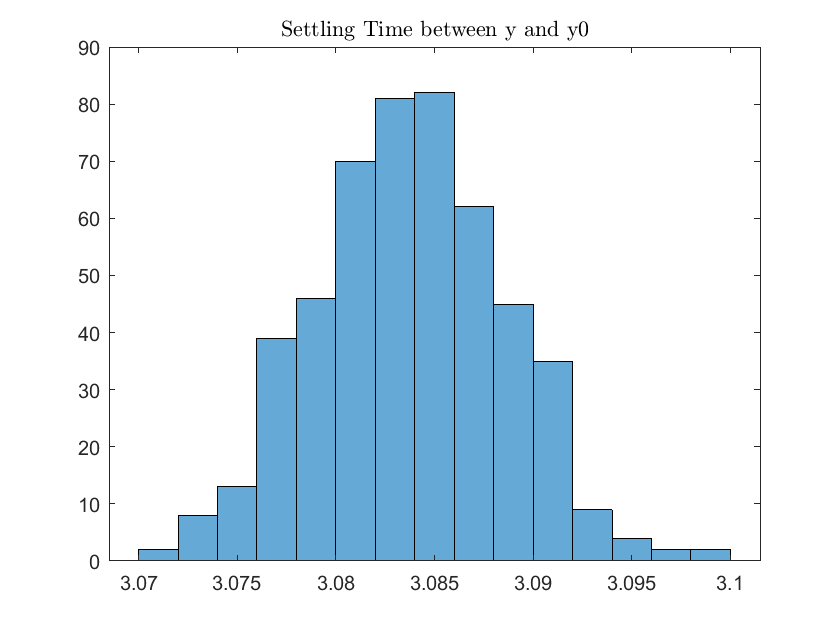

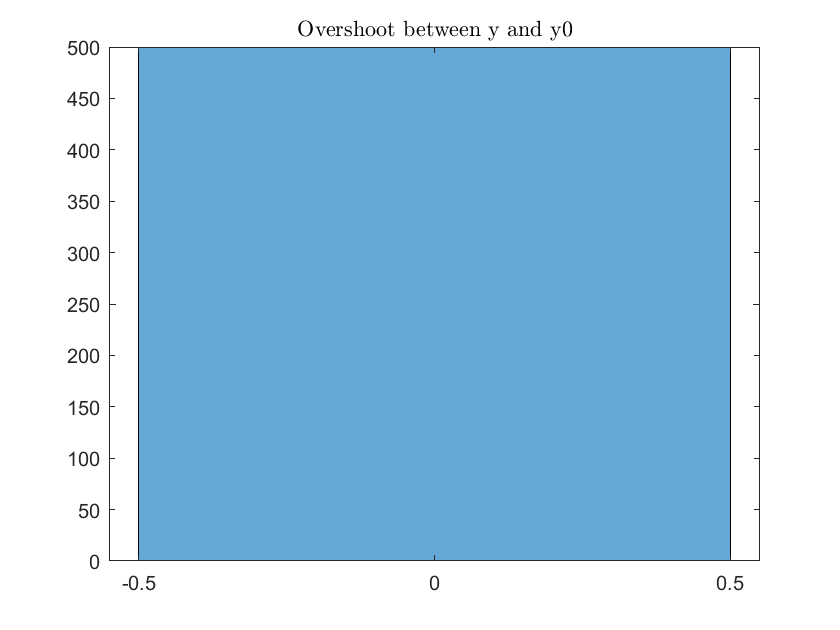

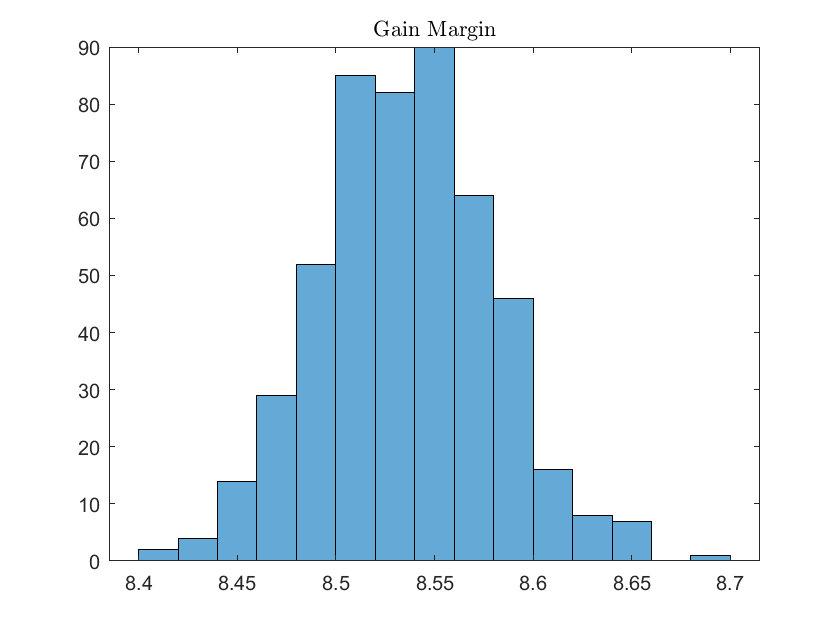

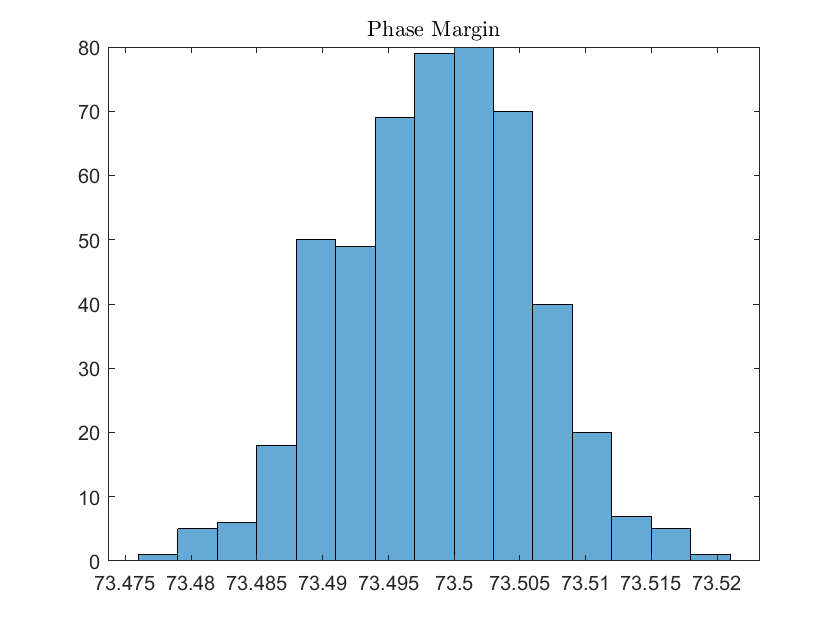

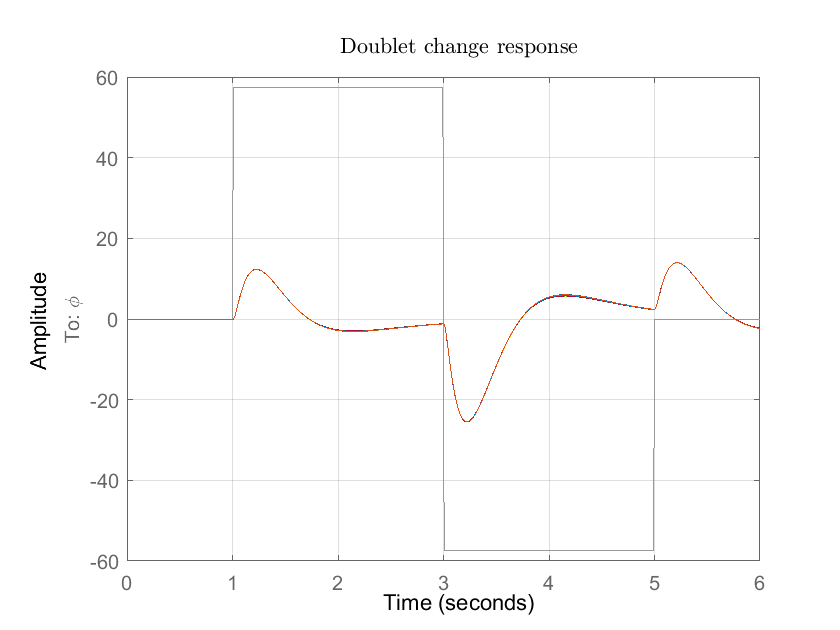

In [9]:
% Monte Carlo study
N=500; poles=zeros(7,N);
stability=zeros(N,1); settlingtime=zeros(N,1); 
overshoot=zeros(N,1); stable_poles=zeros(N,1);
gain_margins=zeros(N,1); phase_margins=zeros(N,1);
controlsens=cell(N,1); stepresponse=zeros(230,N);
t_step = linspace (0,6,500); t_steprep=linspace(0,4,230);
y_doubletchange = 0*(t_step<=1) + 1*(t_step>1 & t_step<= 3)...
                  -1*(t_step>3 & t_step<= 5) + 0*(t_step>5); 

for n=1:N

    % Declare new variables
    L_d=450.7085+0.81/100*abs(450.7085)*randn(1);
    L_v=-5.9755+1.83/100*abs(-5.9755)*randn(1);
    L_p=-2.6478+2.01/100*abs(-2.6478)*randn(1);
    Y_d=-10.1647+1.37/100*abs(-10.1647)*randn(1);
    Y_v=-0.1068+4.26/100*abs(-0.1068)*randn(1);
    Y_p=0.1192+2.03/100*abs(0.1192)*randn(1);

    % Build new model
    A = [Y_v Y_p g 0; L_v L_p 0 0; 0 1 0 0; 1 0 0 0];
    B = [Y_d L_d 0 0]';
    C = [1 0 0 0;0 1 0 0;0 0 1 0;0 0 0 1];
    D = [0;0;0;0];
    sys_new = ss(A,B,C,D);
    sys_new.u = '\delta_{lat}';
    sys_new.y = {'v','p','\phi','y'};
    
    % Creating the connection
    MC = minreal(connect(SumOuter2, tf(setBlockValue(R_y,CL_pos)), tf(setBlockValue(R_v,CL_pos)), SumOuter1, ...
    tf(setBlockValue(R_phi,CL_att)), tf(setBlockValue(R_p,CL_att)), sys_new, 'y_\0', 'y', {'\phi','v_\0','e_y'}),1e-7, false);

    % Defining TF
    F_mc = tf(MC);
    Q_mc= tf(getIOTransfer(MC,'y_\0','\phi'));
    controlsens{n}=Q_mc;

    % Checking for stability
    stability(n)=isstable(MC); 
    poles(1:size(pole(MC)),n)=pole(MC);
    stable_poles(n)=~(any(real(poles(:,n))>1e-7));
    
    % Finding settling time and overshoot
    y_step = step(MC);
    stepresponse(1:size(y_step),n)=y_step;
    ystepinfo = stepinfo(F_mc);
    settlingtime(n) = ystepinfo.SettlingTime;
    overshoot(n) = ystepinfo.Overshoot;

    % Finding phase and gain margins
    S_mc = tf(getIOTransfer(MC,'y_\0','e_y'));
    L_mc = (1-S_mc)/S_mc;
    [gain_margins(n), phase_margins(n)] = margin(L_mc);
     
end

% Outputing results
if ~any(stable_poles)==0; disp('The system is stable'); end
fprintf('The mean overshoot is %d \n', mean(overshoot));
fprintf('The mean settling time is %d \n', mean(settlingtime));
fprintf('The mean phase margin is %d \n', mean(phase_margins));
fprintf('The mean gain margin is %d \n', mean(gain_margins));
%% Plotting
figure; histogram(settlingtime)
title('Settling Time between y and y0','Interpreter','latex')

figure; histogram(overshoot)
title('Overshoot between y and y0','Interpreter','latex')

figure; histogram(gain_margins)
title('Gain Margin','Interpreter','latex')

figure; histogram(phase_margins)
title('Phase Margin','Interpreter','latex')

figure
for i=1:100
lsim(controlsens{i},y_doubletchange*180/pi, t_step); hold on; grid on;
end; title('Doublet change response','Interpreter','latex')